<b> MIS 382N: ADVANCED MACHINE LEARNING<b>

Assignment 5

Total points: 55

Due:  to be submitted via Canvas by 11:59 pm, Mon Nov 21st.

**This can be an individual assignment or group of 2. If you choose to do it as a group, please specify who you are working with (name and EID), then only one student should submit the homework. Put your name and eid here.**

Name: prathmesh savale

EID: ps33296

Name: Aniket Patil

EID: aap3788

In [6]:
# needed to suppress sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Question 1: Ensemble Methods [10 pts]
Read this [article](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db) on different boosting methods. Briefly describe the main advantages and disadvantages of  CatBoost as compared to XGBoost.

## Answer:

Advantages:

In-built support to encode categorical features -

* Supports one-hot encoding and for high-cardinality columns uses efficient method that reduces overfitting.

Faster than XGBoost, in general -
* For most problems, CatBoost builds trees faster than XGBoost due to its internal optimizations.


Disadvantages:

CatBoost does not have any major disadvantages compared to XGBoost, although one is noted below -

Requires additional hyperparameter tuning for categorical variables
* In the article, CatBoost gets best result only after tuning one_hot_max_size, else it performed the worst. So CatBoost only performs well with categorical variables and proper hyperparameter tuning

# Question 2 : Ensemble Methods for Classification [25 pts]

We look at the following dataset [GiveMeSomeCredit](https://www.kaggle.com/c/GiveMeSomeCredit) for this question. The dataset is extremely large so for this question we only consider a subset of the data which has been provided along with the notebook for this assignment.
The task is to predict the probability that someone will experience financial distress in the next two years. The dataset has already been split into train and test sets.

In [7]:
# # Only use this code block if you are using Google Colab.
# # If you are using Jupyter Notebook, please ignore this code block. You can directly upload the file to your Jupyter Notebook file systems.
# from google.colab import files

# ## It will prompt you to select a local file. Click on “Choose Files” then select and upload the file. 
# ## Wait for the file to be 100% uploaded. You should see the name of the file once Colab has uploaded it.
# uploaded = files.upload()

In [8]:
import pandas as pd

data = pd.read_csv('hw5_data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.571373,66,0,0.430620,9274.0,10,0,1,0,0.0
1,0,0.233999,56,0,0.257380,5656.0,12,0,0,0,0.0
2,0,0.299270,33,0,0.114575,4747.0,8,0,0,0,3.0
3,0,0.032165,41,0,0.308326,8490.0,8,0,1,0,0.0
4,0,0.050591,36,0,0.862627,3333.0,8,0,2,0,0.0


In [9]:
from sklearn.model_selection import train_test_split
y = data['SeriousDlqin2yrs']
X = data.drop(['SeriousDlqin2yrs'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 7)

print('train',X_train.shape,y_train.shape)
print('test',X_test.shape,y_test.shape)

train (3750, 10) (3750,)
test (1250, 10) (1250,)


In [10]:
(sum(y_test)/len(y_test)), ((len(y_test) - sum(y_test))/len(y_test)) # this data seems to be imabalanced

(0.068, 0.932)

In this question, we will compare performance of different ensemble methods for classification problems: [Bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html), [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), and [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) Classifiers.



In [16]:
columns_list = list(X.columns)
scores = dict()

In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.metrics import (accuracy_score,roc_auc_score)
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from time import time
%matplotlib inline

a) **[2.5 pts]** Use a Decision Tree Classifier with random_state = 14 for the classification problem. Report the accuracy_score and roc_auc_score on the test data for the classifier.

In [13]:
rfm_clf = DecisionTreeClassifier(random_state=14)
rfm_fitted = rfm_clf.fit(X_train, y_train)
rfm_clf

DecisionTreeClassifier(random_state=14)

In [17]:
y_pred = rfm_fitted.predict(X_test)
y_probs = rfm_fitted.predict_proba(X_test)[:,1]
scores['decision_tree'] = accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_probs)
accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_probs)

(0.888, 0.5854582176218127)

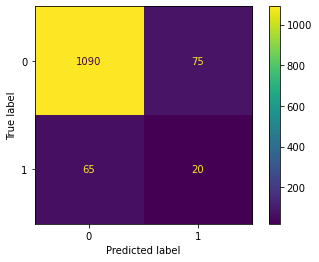

In [18]:
plot_confusion_matrix(rfm_fitted,X_test, y_true=y_test)

b) **[2.5 pts]** Create an ensemble of 25 classifiers (i.e n_estimators = 25) with random_state = 14 for [bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) with base classifier as Decision Tree Classifier from part a). Report accuracy_score and roc_auc_score on the test data for the Bagging classifiers. 

In [19]:
bag_clf = BaggingClassifier(rfm_clf, n_estimators=25, random_state=14)
bag_fitted = bag_clf.fit(X_train, y_train)
bag_clf

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=14),
                  n_estimators=25, random_state=14)

In [21]:
y_pred = bag_fitted.predict(X_test)
y_probs = bag_fitted.predict_proba(X_test)[:,1]
scores['bagging_tree'] = accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_probs)
accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_probs)

(0.9256, 0.7857106791214341)

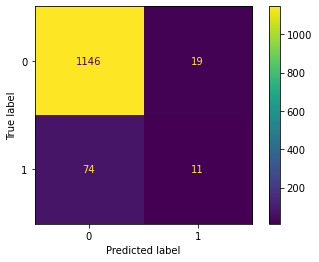

In [22]:
plot_confusion_matrix(bag_fitted, X_test, y_true=y_test)


c) **[5 pts]** Use the training data and build a [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) model for the classification problem. Find the best parameters (including *n_estimators*, *max_features* and *criterion*) using [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Report the optimal parameters obtained by GridSearch. Report the confusion matrix  and [roc_auc_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) on test data using the model fit with best parameters.

In [24]:
# Part c)
clf = RandomForestClassifier()

param_grid = {"n_estimators": [1, 10, 50, 100],
              "max_features": [1, 5, 10, "auto"],
              "criterion": ['gini','entropy'],
              "random_state": [17]}

# Grid search
grid_rfm_clf = GridSearchCV(clf, param_grid=param_grid)
grid_rfm_clf

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [1, 5, 10, 'auto'],
                         'n_estimators': [1, 10, 50, 100],
                         'random_state': [17]})

In [25]:
%%time
grid_rfm_fitted = grid_rfm_clf.fit(X_train, y_train)
grid_rfm_fitted

/home/praths/anaconda3/envs/tf_py38_v2/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/praths/anaconda3/envs/tf_py38_v2/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/praths/anaconda3/envs/tf_py38_v2/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featur

CPU times: user 34.9 s, sys: 21.4 ms, total: 34.9 s
Wall time: 34.9 s


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [1, 5, 10, 'auto'],
                         'n_estimators': [1, 10, 50, 100],
                         'random_state': [17]})

In [28]:
# best paramters
grid_rfm_fitted.best_params_

{'criterion': 'entropy',
 'max_features': 1,
 'n_estimators': 100,
 'random_state': 17}

In [29]:
y_pred = grid_rfm_fitted.best_estimator_.predict(X_test)
y_probs = grid_rfm_fitted.predict_proba(X_test)[:,1]
scores['rfm'] = accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_probs)
accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_probs)

(0.932, 0.8375612219136582)

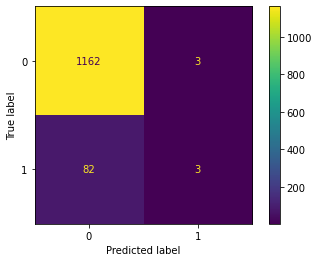

In [30]:
plot_confusion_matrix(grid_rfm_fitted, X_test, y_true=y_test)


d) **[5 pts]** Use [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) for this problem. Again, find the best parameters (including *n_estimators, learning_rate*), and report the confusion matrix and roc_auc_score on test data for the classifier fit with best parameters found using training data.


In [31]:
# Part d)

clf = AdaBoostClassifier()

param_grid = {"n_estimators": [10, 100],
          "learning_rate": [0.01, 0.1, 0.5],
          "random_state": [17]
          }

# Grid search
grid_ada_clf = GridSearchCV(clf, param_grid=param_grid)
grid_ada_clf

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'n_estimators': [10, 100], 'random_state': [17]})

In [32]:
%%time
grid_ada_fitted = grid_ada_clf.fit(X_train, y_train)
grid_ada_fitted

CPU times: user 5.29 s, sys: 0 ns, total: 5.29 s
Wall time: 5.29 s


GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'n_estimators': [10, 100], 'random_state': [17]})

In [34]:
# best paramters
grid_ada_fitted.best_params_

{'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 17}

In [35]:
y_pred = grid_ada_fitted.best_estimator_.predict(X_test)
y_probs = grid_ada_fitted.predict_proba(X_test)[:,1]
scores['adaboost'] = accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_probs)
accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_probs)

(0.9328, 0.8390254986114618)

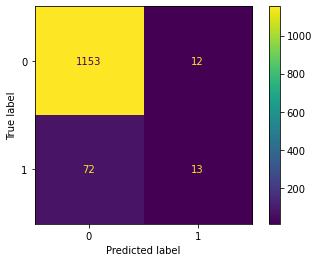

In [36]:
plot_confusion_matrix(grid_ada_fitted, X_test, y_true=y_test)


e) **[5 pts]** Use [Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) for this problem. Again, find the best parameters (including *n_estimators, learning_rate*), and report the confusion matrix and roc_auc_score on test data for the classifier fit with best parameters found using training data.

In [37]:
# Part e)

clf = GradientBoostingClassifier()

param_grid = {"n_estimators": [10, 100],
          "learning_rate": [0.01, 0.1, 0.5],
          "random_state": [17]
          }
# Grid search
grid_gbm_clf = GridSearchCV(clf, param_grid=param_grid)
grid_gbm_clf

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'n_estimators': [10, 100], 'random_state': [17]})

In [38]:
%%time
grid_gbm_fitted = grid_gbm_clf.fit(X_train, y_train)
grid_gbm_fitted

CPU times: user 6.95 s, sys: 0 ns, total: 6.95 s
Wall time: 6.95 s


GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'n_estimators': [10, 100], 'random_state': [17]})

In [39]:
# best paramters
grid_gbm_fitted.best_params_

{'learning_rate': 0.1, 'n_estimators': 10, 'random_state': 17}

In [40]:
y_pred = grid_gbm_fitted.best_estimator_.predict(X_test)
y_probs = grid_gbm_fitted.predict_proba(X_test)[:,1]
scores['gbm'] = accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_probs)
accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_probs)

(0.932, 0.8366372128250441)

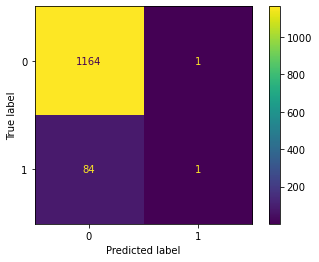

In [41]:
plot_confusion_matrix(grid_gbm_fitted, X_test, y_true=y_test)




f) **[5 pts]** Compare the performance of decision tree from part a) with the ensemble methods, Briefly explain which of the three ensemble method performed better and why?

In [42]:
# scores - (accuracy score, AUC_ROC_score)
scores

{'decision_tree': (0.888, 0.5854582176218127),
 'bagging_tree': (0.9256, 0.7857106791214341),
 'rfm': (0.932, 0.8375612219136582),
 'adaboost': (0.9328, 0.8390254986114618),
 'gbm': (0.932, 0.8366372128250441)}

* Decision tree classfier performs worst compared to any of the ensemble methods
* Although the ensemble methods have a marginally better accuracy and AUC score. This can be attributed to the class imabalance, we calculated previously, because ensembles will tend to fit class imbalance better 
* Of the 3 ensemble methods Adaboost has the best performance. It performs better than GBM because gbm is more prone to overfitting


## Question 3: XGBoost on Datasets with varying Class Imbalance [15 points]

You are given three datasets (all extracted from the [GiveMeSomeCredit](https://www.kaggle.com/c/GiveMeSomeCredit) dataset which was used in the last question). They have varying levels of class imbalance (positive to negative class ratio):
1. dataset_equally_biased_final has a class ratio of 1:1
2. dataset_originally_biased_final has a class ratio of 1:15
3. dataset_highly_biased_final has a class ratio of 1:39

Use [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_api.html) on these three datasets and plot the [calibration curves](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html#sklearn.calibration.calibration_curve) for your predictions. Examine both uniform and quantile binning strategies for your plots and observe how the plots look. For which of the datasets is you model calibrated the best? Which of the binning strategies provide more informative visualization for each of the datasets?

In [99]:
# # Only use this code block if you are using Google Colab.
# # If you are using Jupyter Notebook, please ignore this code block. You can directly upload the file to your Jupyter Notebook file systems.
# from google.colab import files

# ## It will prompt you to select a local file. Click on “Choose Files” then select and upload the file. 
# ## Wait for the file to be 100% uploaded. You should see the name of the file once Colab has uploaded it.
# uploaded = files.upload()

In [43]:
from sklearn.model_selection import train_test_split
import pandas as pd

dataset = pd.read_csv("data_equally_biased_final.csv")
X = dataset.drop(['SeriousDlqin2yrs'], axis=1)
y = dataset['SeriousDlqin2yrs']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.2, random_state = 15, stratify = y)
print("Balanced Dataset")
# Number of classes in training Data
print(y_train1.value_counts())
# Number of classes in test Data
print(y_test1.value_counts())

dataset = pd.read_csv("data_originally_biased_final.csv")
X = dataset.drop(['SeriousDlqin2yrs'], axis=1)
y = dataset['SeriousDlqin2yrs']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.2, random_state = 15, stratify = y)
print("Originally Imbalanced Dataset")
# Number of classes in training Data
print(y_train2.value_counts())
# Number of classes in test Data
print(y_test2.value_counts())

dataset = pd.read_csv("data_highly_biased_final.csv")
X = dataset.drop(['SeriousDlqin2yrs'], axis=1)
y = dataset['SeriousDlqin2yrs']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size = 0.2, random_state = 15, stratify = y)
print("Highly Imbalanced Dataset")
# Number of classes in training Data
print(y_train3.value_counts())
# Number of classes in test Data
print(y_test3.value_counts())

Balanced Dataset
0    4000
1    4000
Name: SeriousDlqin2yrs, dtype: int64
0    1000
1    1000
Name: SeriousDlqin2yrs, dtype: int64
Originally Imbalanced Dataset
0    7466
1     534
Name: SeriousDlqin2yrs, dtype: int64
0    1866
1     134
Name: SeriousDlqin2yrs, dtype: int64
Highly Imbalanced Dataset
0    7800
1     200
Name: SeriousDlqin2yrs, dtype: int64
0    1950
1      50
Name: SeriousDlqin2yrs, dtype: int64


In [44]:
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.metrics import (accuracy_score,roc_auc_score)
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from time import time
import xgboost

%matplotlib inline

In [46]:
# Using the earlier dataset and applying XGBoost on it

clf = xgboost.XGBClassifier()

param_grid = {"n_estimators": [10, 100],
          "learning_rate": [0.01, 0.1, 0.5],
          "random_state": [17]
          }

# Grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)

# Balanced Dataset
print("Balanced Dataset")
grid_search.fit(X_train1, y_train1)
print(grid_search.best_params_)
clf.set_params(**grid_search.best_params_)

t0 = time()
clf.fit(X_train1, y_train1)
print("training time", round(time()-t0, 3), "s")

t0 = time()
y_pred_gbt1 = clf.predict(X_test1)
print("predict time", round(time()-t0, 3), "s")

print("XGBoost conf matrix: ")
print(confusion_matrix(y_test1, y_pred_gbt1))

y_pred_proba1 = clf.predict_proba(X_test1)[:,1]

acc_score = accuracy_score(y_test1,y_pred_gbt1)
auc_score = roc_auc_score(y_test1,y_pred_proba1)
print("Accuracy: {}\n AUC_ROC: {}\n".format(acc_score,auc_score))


# Originally Imbalanced Dataset

print("Originally Imbalanced Dataset")
grid_search.fit(X_train2, y_train2)
print(grid_search.best_params_)
clf.set_params(**grid_search.best_params_)

t0 = time()
clf.fit(X_train2, y_train2)
print("training time", round(time()-t0, 3), "s")

t0 = time()
y_pred_gbt2 = clf.predict(X_test2)
print("predict time", round(time()-t0, 3), "s")

print("XGBoost conf matrix: ")
print(confusion_matrix(y_test2, y_pred_gbt2))

y_pred_proba2 = clf.predict_proba(X_test2)[:,1]

acc_score = accuracy_score(y_test2,y_pred_gbt2)
auc_score = roc_auc_score(y_test2,y_pred_proba2)
print("Accuracy: {}\n AUC_ROC: {}\n".format(acc_score,auc_score))

# Highly Imalanced Dataset

print("Highly Imbalanced Dataset")
grid_search.fit(X_train3, y_train3)
print(grid_search.best_params_)
clf.set_params(**grid_search.best_params_)

t0 = time()
clf.fit(X_train3, y_train3)
print("training time", round(time()-t0, 3), "s")

t0 = time()
y_pred_gbt3 = clf.predict(X_test3)
print("predict time", round(time()-t0, 3), "s")

print("XGBoost conf matrix: ")
print(confusion_matrix(y_test3, y_pred_gbt3))

y_pred_proba3 = clf.predict_proba(X_test3)[:,1]

acc_score = accuracy_score(y_test3,y_pred_gbt3)
auc_score = roc_auc_score(y_test3,y_pred_proba3)
print("Accuracy: {}\n AUC_ROC: {}\n".format(acc_score,auc_score))

Balanced Dataset
{'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 17}
training time 0.343 s
predict time 0.004 s
XGBoost conf matrix: 
[[794 206]
 [228 772]]
Accuracy: 0.783
 AUC_ROC: 0.856863

Originally Imbalanced Dataset
{'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 17}
training time 0.31 s
predict time 0.003 s
XGBoost conf matrix: 
[[1843   23]
 [ 114   20]]
Accuracy: 0.9315
 AUC_ROC: 0.8342691686263217

Highly Imbalanced Dataset
{'learning_rate': 0.01, 'n_estimators': 100, 'random_state': 17}
training time 0.306 s
predict time 0.003 s
XGBoost conf matrix: 
[[1945    5]
 [  50    0]]
Accuracy: 0.9725
 AUC_ROC: 0.8398564102564102



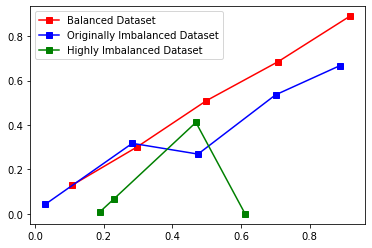

In [47]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

#Plot all calibration curves for strategy = 'uniform' (It is uniform by default)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test1, y_pred_proba1)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='red', label='Balanced Dataset')
fraction_of_positives, mean_predicted_value = calibration_curve(y_test2, y_pred_proba2)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='blue', label='Originally Imbalanced Dataset')
fraction_of_positives, mean_predicted_value = calibration_curve(y_test3, y_pred_proba3)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='green', label='Highly Imbalanced Dataset')
plt.legend()


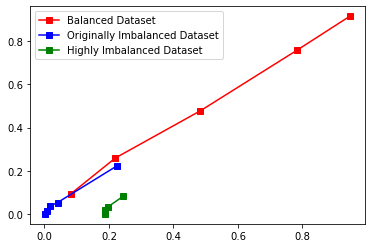

In [48]:
#Plot all calibration curves for strategy = 'quantile'
fraction_of_positives, mean_predicted_value = calibration_curve(y_test1, y_pred_proba1, strategy='quantile')
plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='red', label='Balanced Dataset')
fraction_of_positives, mean_predicted_value = calibration_curve(y_test2, y_pred_proba2, strategy='quantile')
plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='blue', label='Originally Imbalanced Dataset')
fraction_of_positives, mean_predicted_value = calibration_curve(y_test3, y_pred_proba3, strategy='quantile')
plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='green', label='Highly Imbalanced Dataset')
plt.legend()


Balanced dataset has the best calibration because it most closely follows perfectly calibrated curve (which would be y=x line) 

Binning strategy with more informative visualization for each dataset -

Balanced - Both uniform and quantile work well

Originally Imbalanced - Quantile

Highly Imbalanded - Quantile

The quantile strategy is more informative for imbalanced datasets because each bin gets equal number of samples and we get a better idea about calibration of the model. On the other hads, since imbalanced datasets have less positive samples, uniform binning will result in less positive samples in bins with higher mean predicted probability. For e.g., In uniform binning of highly imbalanced dataset, the last bin has no positive samples (as can be seen from y-axis value being 0).

reference -  https://datascience.stackexchange.com/questions/77445/why-does-my-calibration-curve-for-platts-and-isotonic-have-less-points-than-my-u

# Question 4: Deep Learning Mechanisms [5 points]

Briefly explain the motivation behind the following mechanisms commonly used in deep learning: <br>
a) **[2.5 pts]** Skip connections <br>
b) **[2.5 pts]** Batch normalization

# Answer:

(a)
* Skip connections are used to train very deep neural networks that suffer from degradation problem. Degradation problem is basically that we get higher training error for deeper networks than shallow networks, so the problem is not overfitting, instead its degradation. This is because of deeper network's inability to propagate results from earlier to deeper layers without any modification, which can be acheived by deeper layers learning an identity function. Skip connections solve this problem by allowing results from initial layers to propagate directly to deeper layers, essentially behaving like an identity function. This was also the primary motivation behind ResNet.

* Another motivation for skip-connections is feature reusability, For e.g., DenseNet has skip connections from each layer to all layers ahead of it which causes features to be resused at each layer 

(b)

* Batch normalization is used to resolve the problem of internal covariate shift. Basically, at each weight update step, our model is chasing a moving target since data in each batch can have a different distribution. So, it reduces the dependence of gradients on the scale of the parameters or their initial values. This in turn allows us to create deeper neural networks.

* Batch normalisation  also has a regularising effect since it adds noise to the inputs of every layer so you can avoid adding dropout. This reduces overfitting since the model no longer produces deterministic values for a given training example.